In [12]:
import numpy as np
from functools import partial
import PIL.Image
import tensorflow as tf
import urllib.request
import os
import zipfile
from io import BytesIO
from IPython.display import Image
#import cv2

In [13]:
# download inception
# create tf session
# pick a layer to enhance our image
# apply graident ascent to that layer
# output deep dreamed image

In [14]:
#make sure googlenet model is ../data/tensorflow_inception_graph.pb
model_fn = 'tensorflow_inception_graph.pb'
data_dir = '../data'

#step 1 - creating Tensorflow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(os.path.join(data_dir, model_fn), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') #define input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

#list of layers = graph.get_operations()
#graph.get_operations()

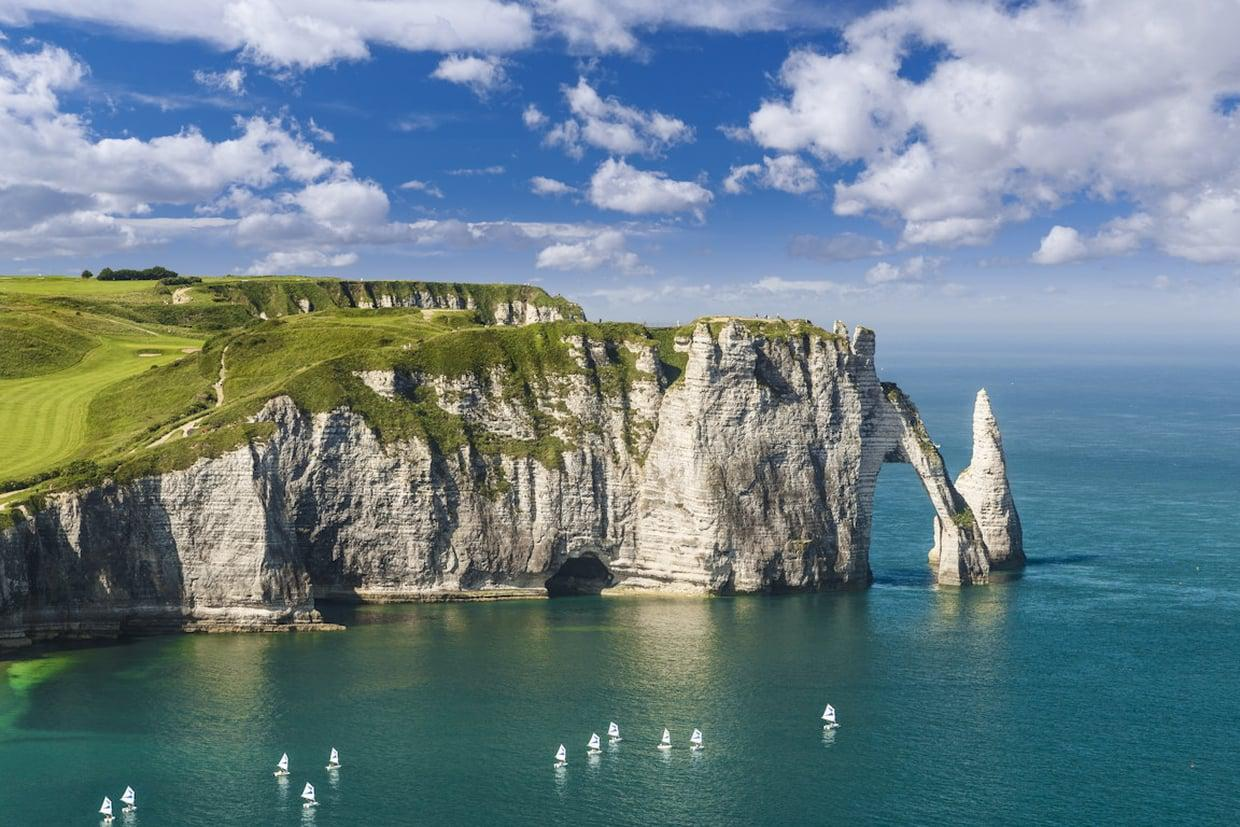

In [15]:
def showarray(a, fmt='jpeg'): # display a pdf, a has to be an int -> np.float32() and /255
        a = np.uint8(np.clip(a, 0, 1)*255)
        f = BytesIO()
        PIL.Image.fromarray(a).save(f, fmt)
        display(Image(data=f.getvalue()))

showarray(np.float32(PIL.Image.open('../paysage1.jpg'))/255)

In [16]:
def T(layer):
    #'''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)
    
def tffunc(*argtypes):
    #'''Helper that transforms TF-graph generating function into a regular one.
    #See "resize" function below.
    #'''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap
    
# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]

resize = tffunc(np.float32, np.int32)(resize)
    
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def calc_grad_tiled(img, t_grad, tile_size=512):
    #'''Compute the value of tensor t_grad over the image in a tiled way.
    #Random shifts are applied to the image to blur tile boundaries over 
    #multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

In [17]:
layers = [op.name for op in graph.get_operations() if op.type == 'Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]
    
#print('Numbers of layers', len(layers))
#print('Total number of feature channels:', sum(feature_nums))

In [18]:
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def render_deepdream(t_obj, img0=img_noise, iter_n = 10, step = 1.5, octave_n = 4, octave_scale = 1.4):
    t_score = tf.reduce_mean(t_obj) #defining optimization objective
    t_grad = tf.gradients(t_score, t_input)[0]
        
    #split the image into a number of octaves
    img = img0
    octaves = []
    for _ in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img - resize(lo, hw)
        img = lo
        octaves.append(hi)
            
    #generate details octave by octave
    for octave in range(octave_n):
        if octave > 0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2]) + hi
        for _ in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean() + 1e-7))
        #step 5 - output deepdreamed image
    showarray(img/255.0)
    #return img

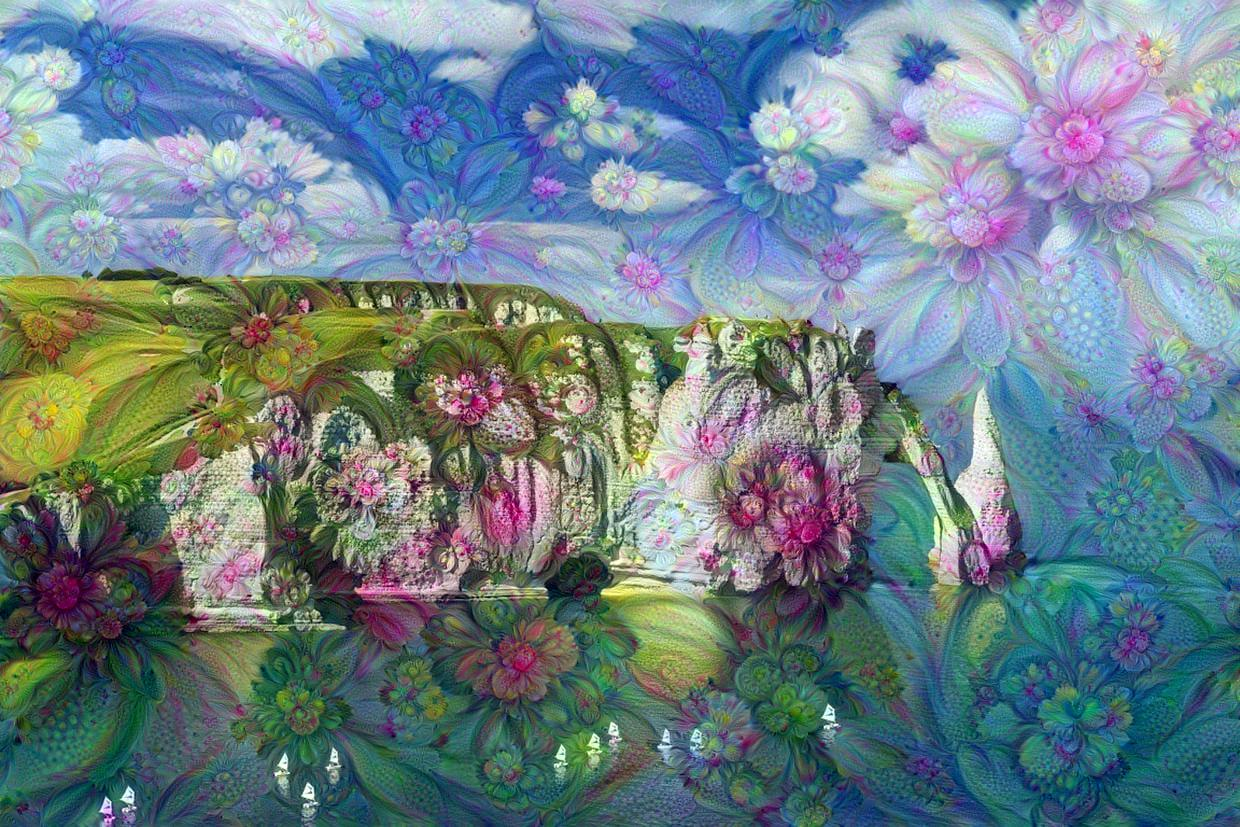

In [67]:
#step 3 - Pick a layer to enhance our image
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139
    
img0 = PIL.Image.open('../paysage1.jpg')
img0 = np.float32(img0)
    
#step 4 - Apply graident ascent to that layer
final = render_deepdream((T(layer)[:,:,:,139]), img0, iter_n = 10, step = 1.5, octave_n = 10, octave_scale = 1.4)
#cv2.imwrite(data_dir+'/'+"test".zfill(3)+'.jpg',final)

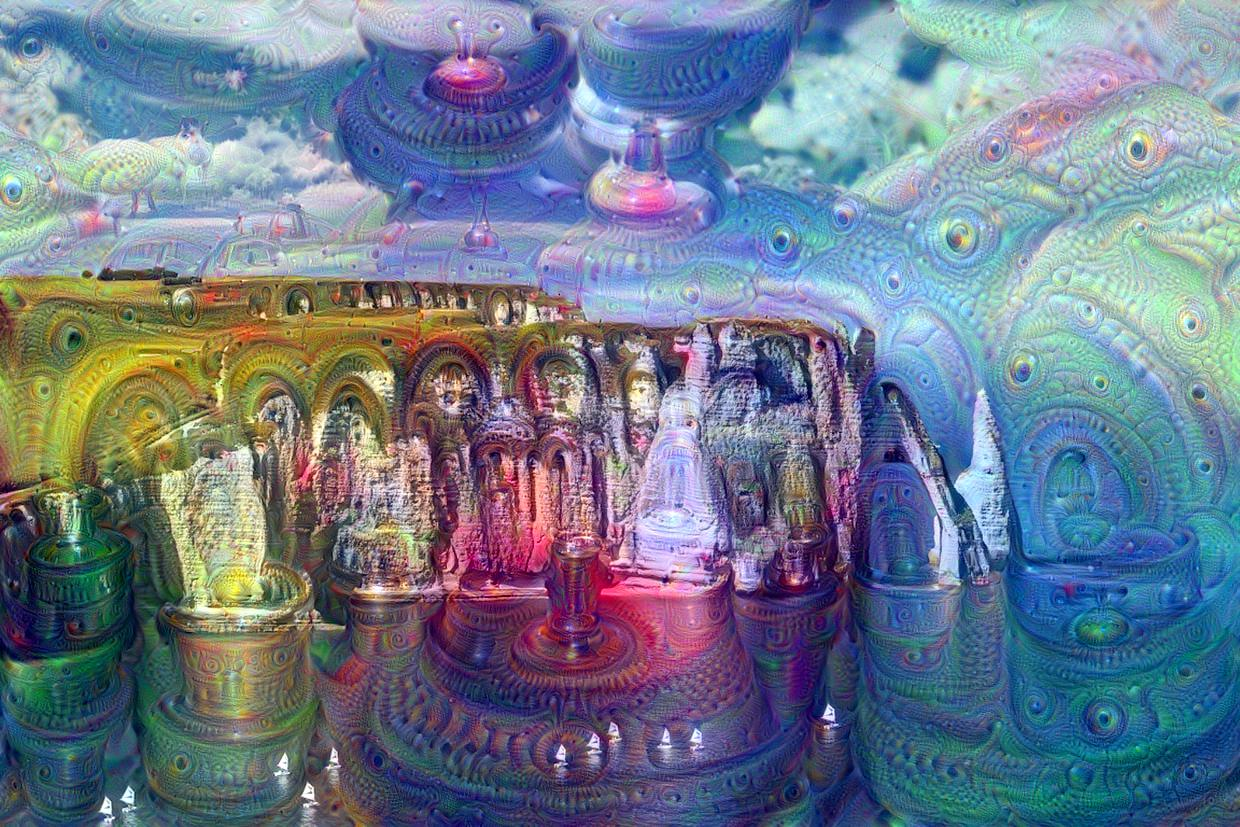

In [82]:
render_deepdream(tf.square(T('mixed4c')), img0, iter_n = 10, step = 1.5, octave_n = 15, octave_scale = 1.4)

In [19]:
def dreamable_shape(name):

    # to find layers to deepdream with we want to match ones with the same shapes/dims as the examples (?,?,?,int)
    target_shape = tf.TensorShape([None, None, None, 512])# T("mixed4d_3x3_bottleneck_pre_relu").shape
    target_dims = len(target_shape)

    # add layer names here to ignore them while dreaming
    ignore_layers = ["avgpool0"] # processing avgpool0 generates an error ("computed output size would be negative")

    if name in ignore_layers: return False

    layer = T(name)

    if layer.shape.dims is None: return False
    if not len(layer.shape) is target_dims: return False

    for x in range(0, target_dims):
        if not type(layer.shape[x].value) is type(target_shape[x].value):
            return False

    return True

def setup_layers():
    names = None

    if a.layer_names is not None:
        # use a custom list of tensor names
        print("loading layer names from file:", a.layer_names)
        with open(a.layer_names) as f:
            lines = f.read().splitlines()
            names = [n for n in lines if dreamable_shape(n)]
    else:
        # use all of the dreamable tensors in the graph
        names = [n.name for n in graph_def.node if dreamable_shape(n.name)]


    feature_counts = [int(T(n).get_shape()[-1]) for n in names]
    feature_count = sum(feature_counts)

    print('Loaded model:', model_fn)
    print('Number of layers', len(names))
    print('Total number of feature channels:', feature_count)

    return names

In [74]:
setup_layers()

Loaded model: tensorflow_inception_graph.pb
Number of layers 203
Total number of feature channels: 35640


['conv2d0_pre_relu/conv',
 'conv2d0_pre_relu',
 'conv2d0',
 'maxpool0',
 'localresponsenorm0',
 'conv2d1_pre_relu/conv',
 'conv2d1_pre_relu',
 'conv2d1',
 'conv2d2_pre_relu/conv',
 'conv2d2_pre_relu',
 'conv2d2',
 'localresponsenorm1',
 'maxpool1',
 'mixed3a_1x1_pre_relu/conv',
 'mixed3a_1x1_pre_relu',
 'mixed3a_1x1',
 'mixed3a_3x3_bottleneck_pre_relu/conv',
 'mixed3a_3x3_bottleneck_pre_relu',
 'mixed3a_3x3_bottleneck',
 'mixed3a_3x3_pre_relu/conv',
 'mixed3a_3x3_pre_relu',
 'mixed3a_3x3',
 'mixed3a_5x5_bottleneck_pre_relu/conv',
 'mixed3a_5x5_bottleneck_pre_relu',
 'mixed3a_5x5_bottleneck',
 'mixed3a_5x5_pre_relu/conv',
 'mixed3a_5x5_pre_relu',
 'mixed3a_5x5',
 'mixed3a_pool',
 'mixed3a_pool_reduce_pre_relu/conv',
 'mixed3a_pool_reduce_pre_relu',
 'mixed3a_pool_reduce',
 'mixed3a',
 'mixed3b_1x1_pre_relu/conv',
 'mixed3b_1x1_pre_relu',
 'mixed3b_1x1',
 'mixed3b_3x3_bottleneck_pre_relu/conv',
 'mixed3b_3x3_bottleneck_pre_relu',
 'mixed3b_3x3_bottleneck',
 'mixed3b_3x3_pre_relu/conv',
 

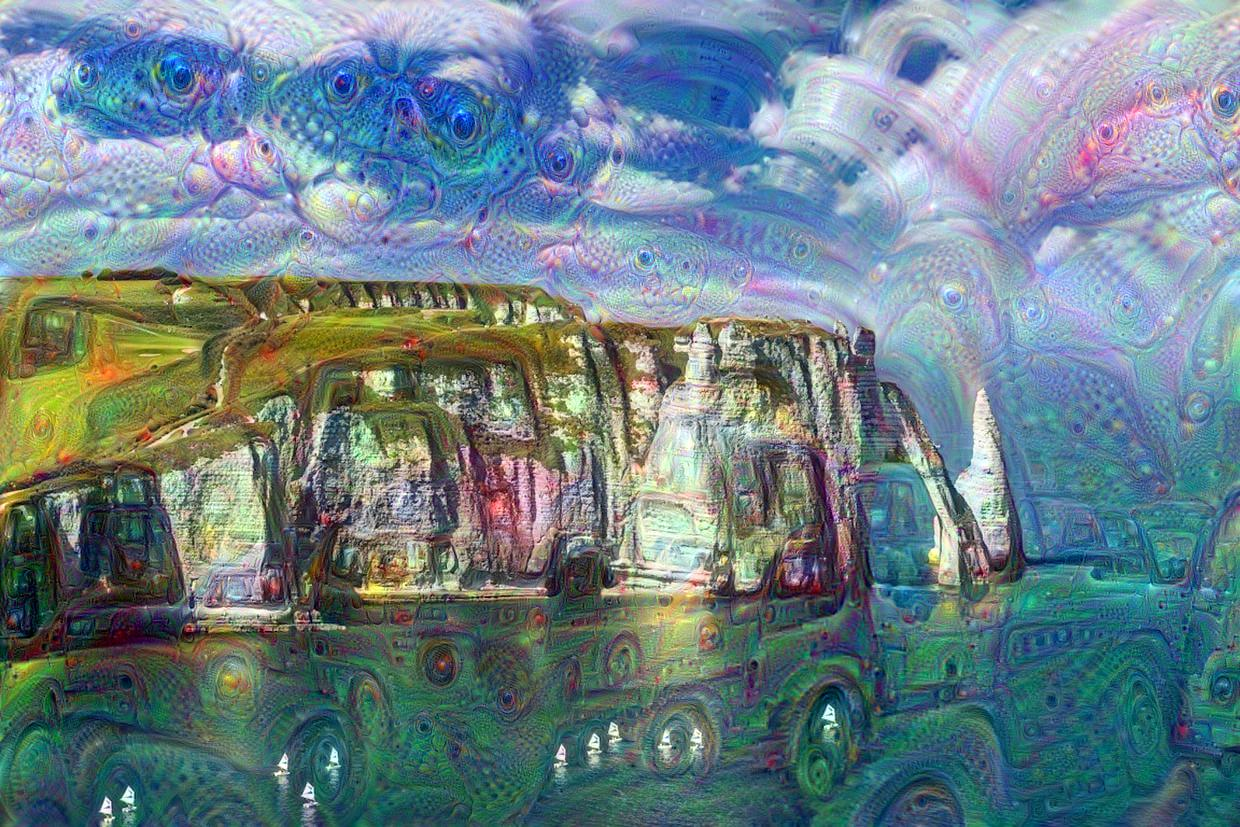

In [76]:
render_deepdream(tf.square(T('mixed4d')), img0, iter_n = 10, step = 1.5, octave_n = 10, octave_scale = 1.4)

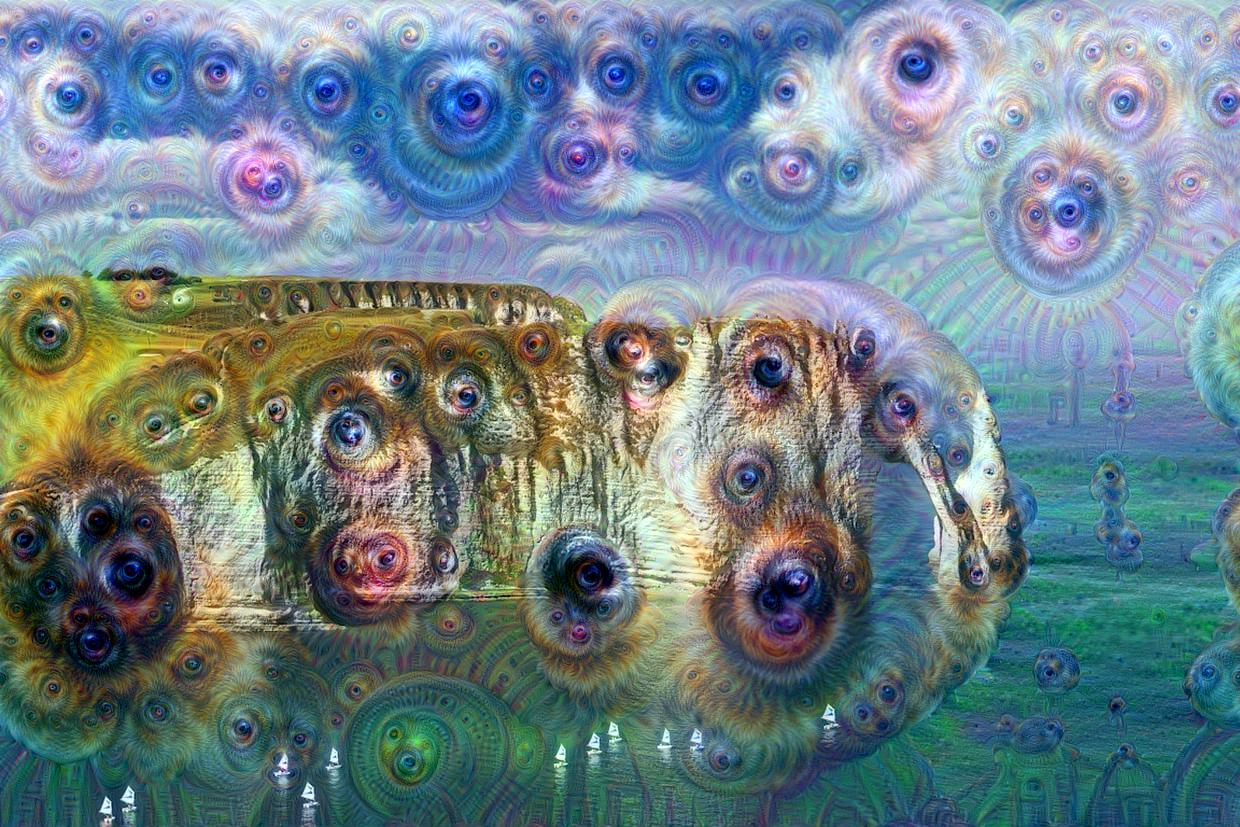

In [77]:
render_deepdream(tf.square(T('mixed4a')), img0, iter_n = 10, step = 1.5, octave_n = 10, octave_scale = 1.4)

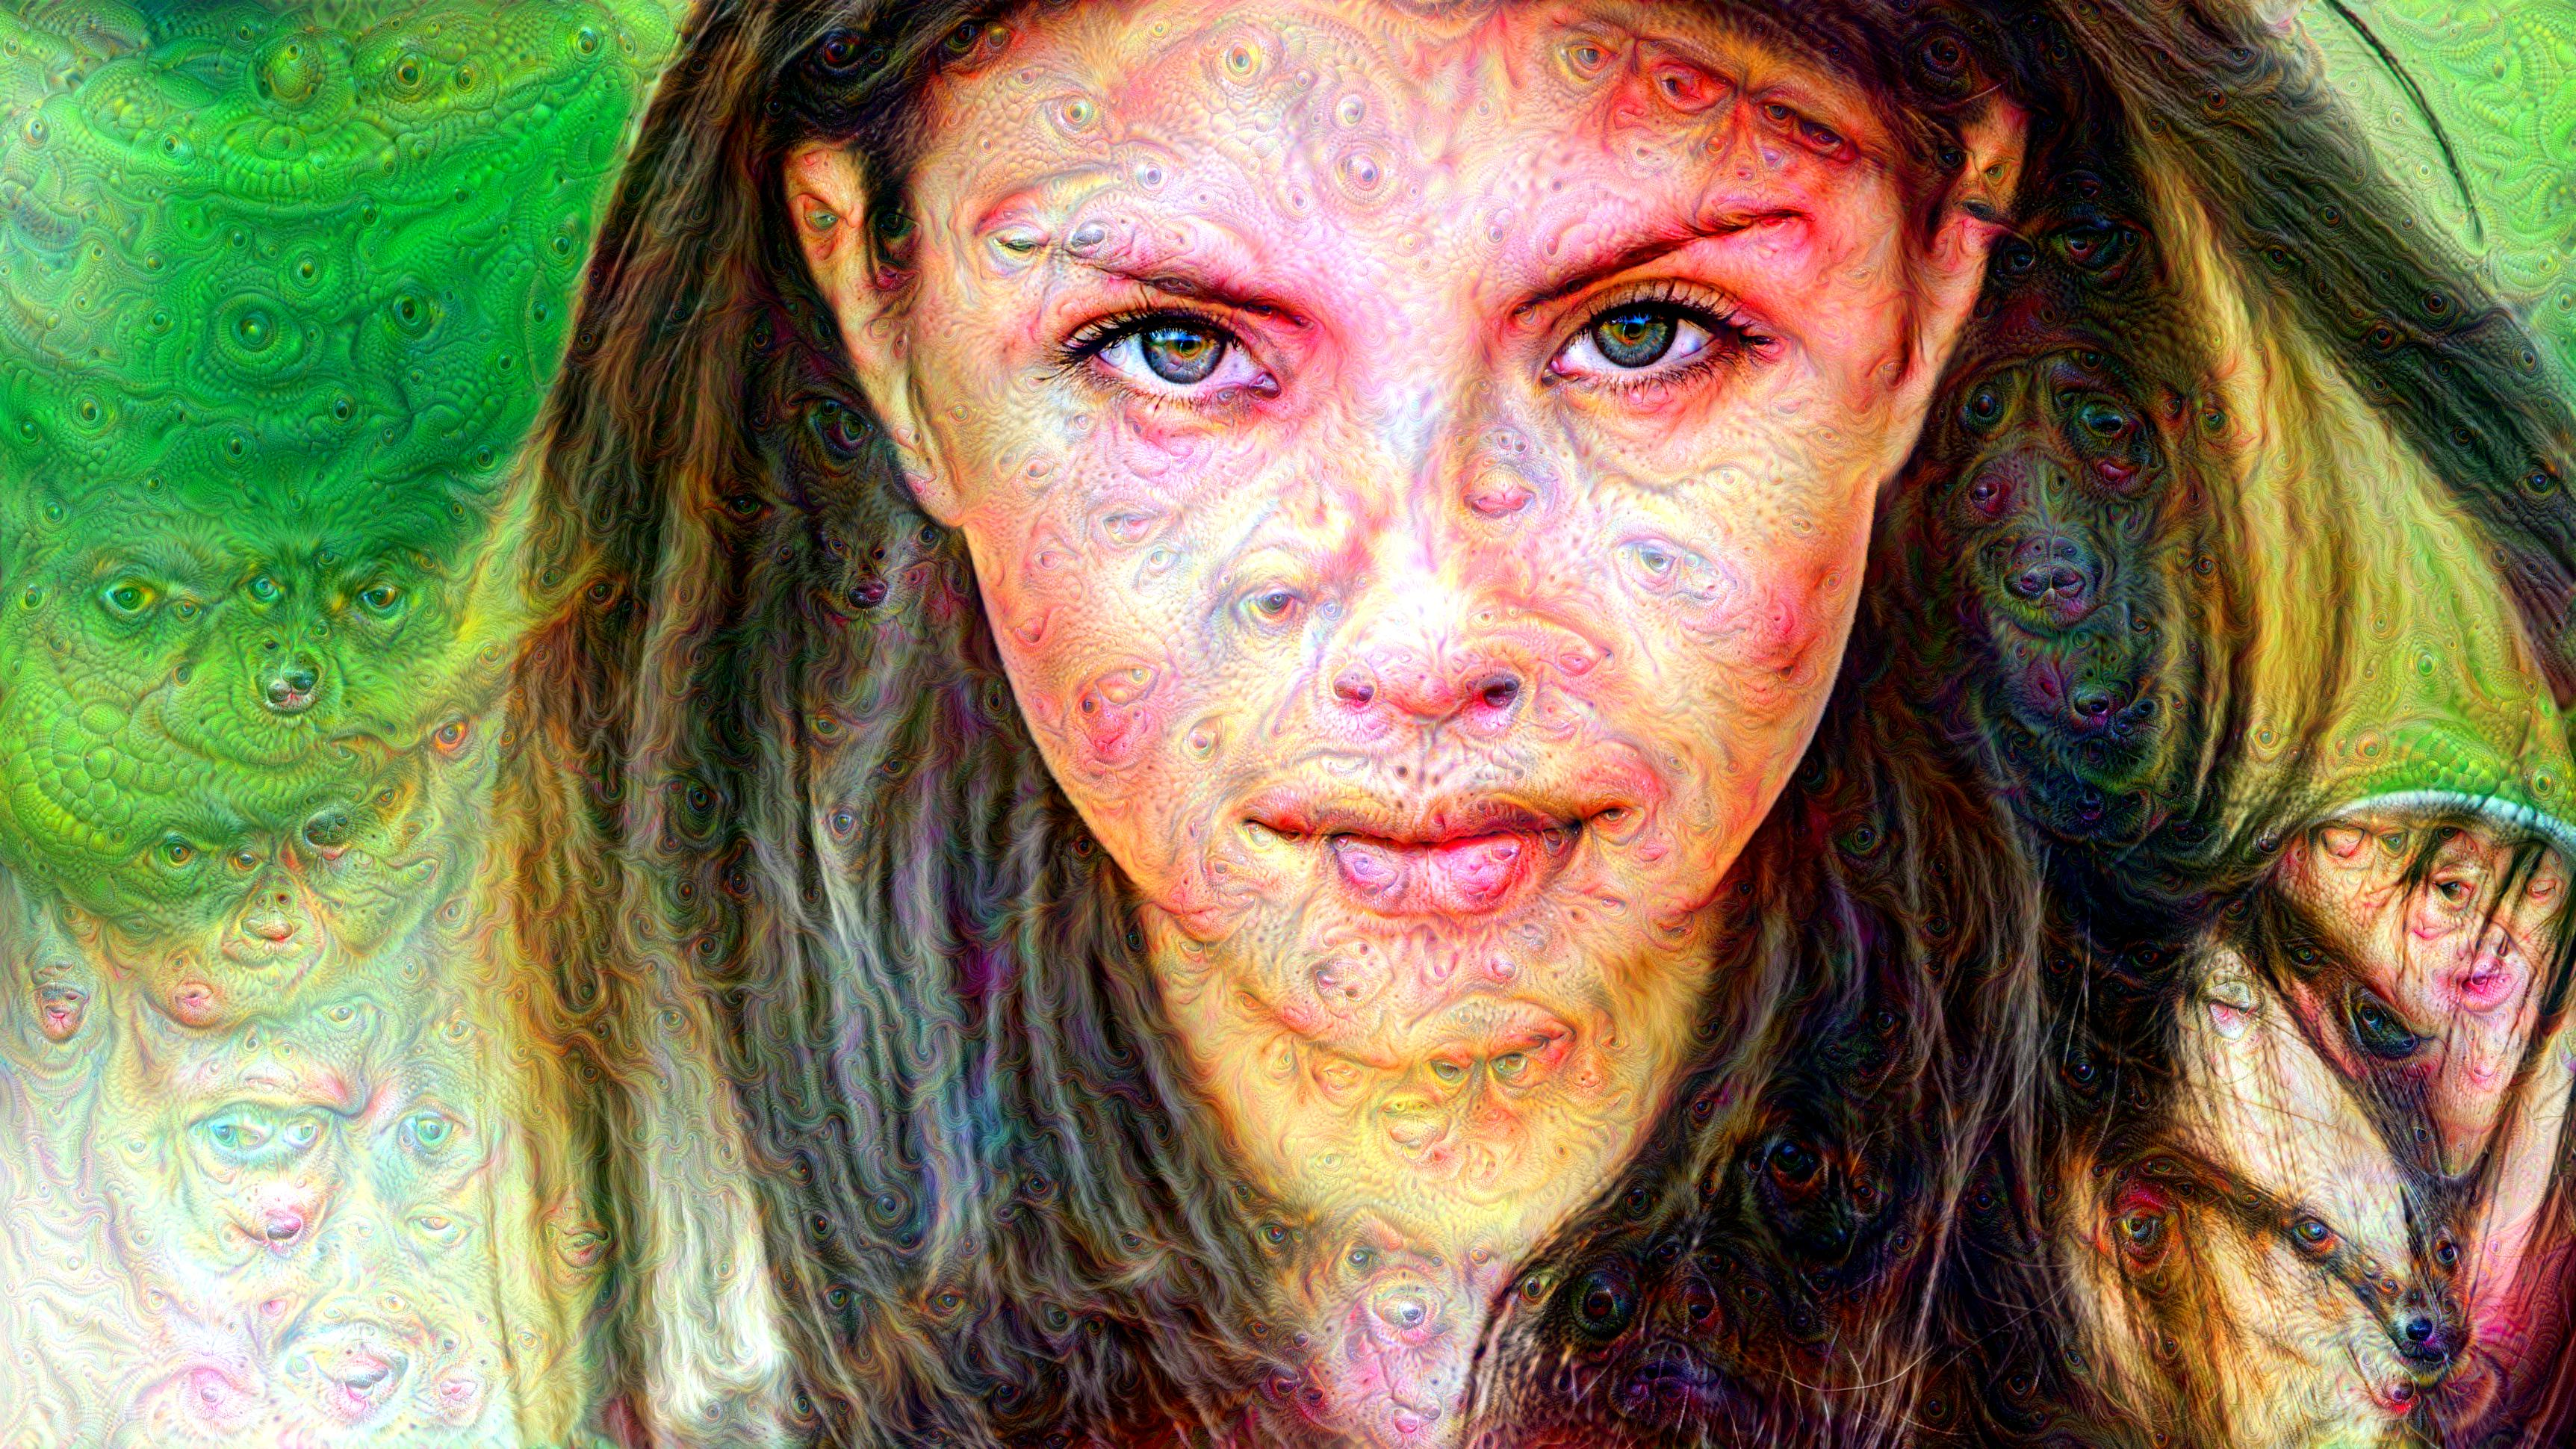

In [20]:
img1 = PIL.Image.open('../portrait1.jpg')
img1 = np.float32(img1)
render_deepdream(tf.square(T('mixed4c')), img1, iter_n = 10, step = 1.5, octave_n = 15, octave_scale = 1.4)

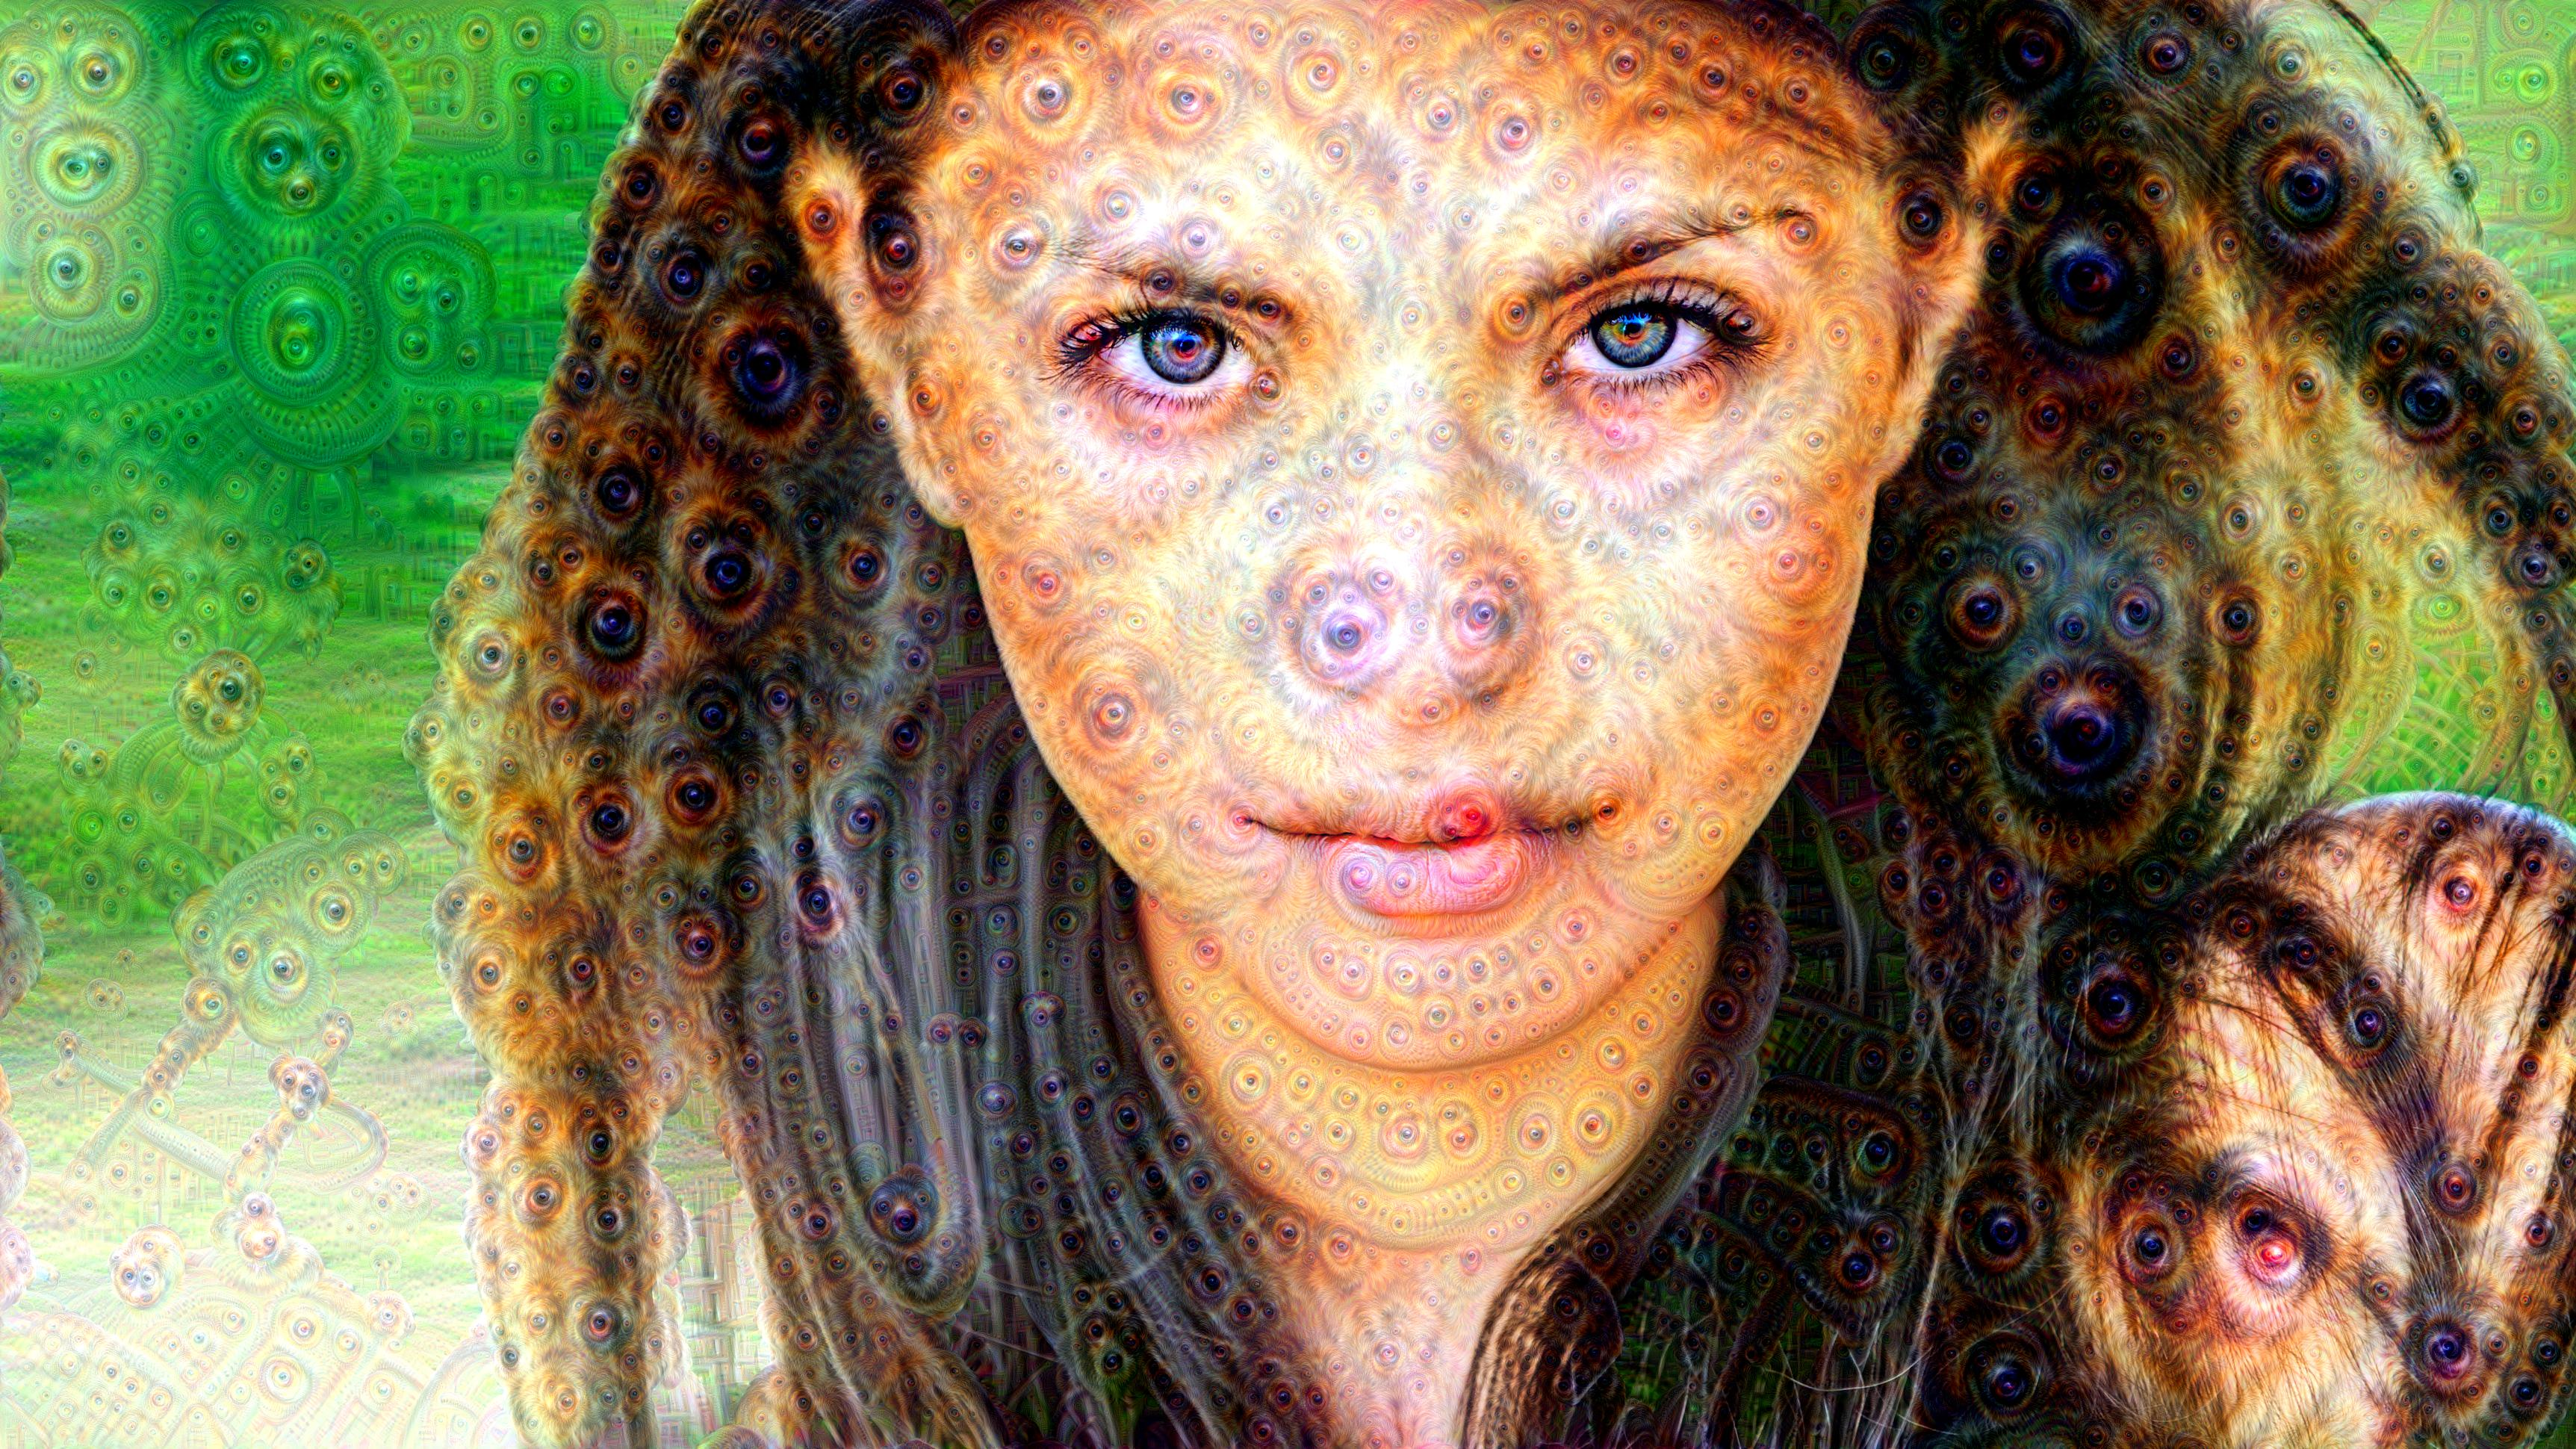

In [21]:
render_deepdream(tf.square(T('mixed4a')), img1, iter_n = 10, step = 1.5, octave_n = 10, octave_scale = 1.4)

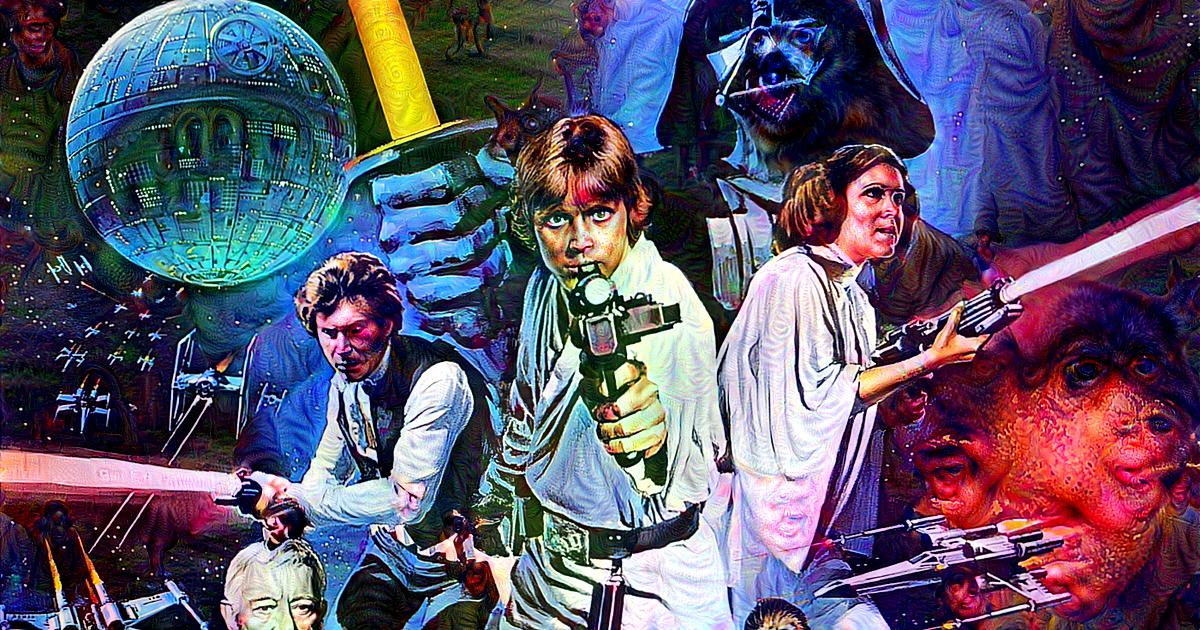

In [24]:
img1 = PIL.Image.open('../sw1.png')
img1 = np.float32(img1)
render_deepdream(tf.square(T('mixed4c')), img1, iter_n = 10, step = 1.5, octave_n = 15, octave_scale = 1.4)

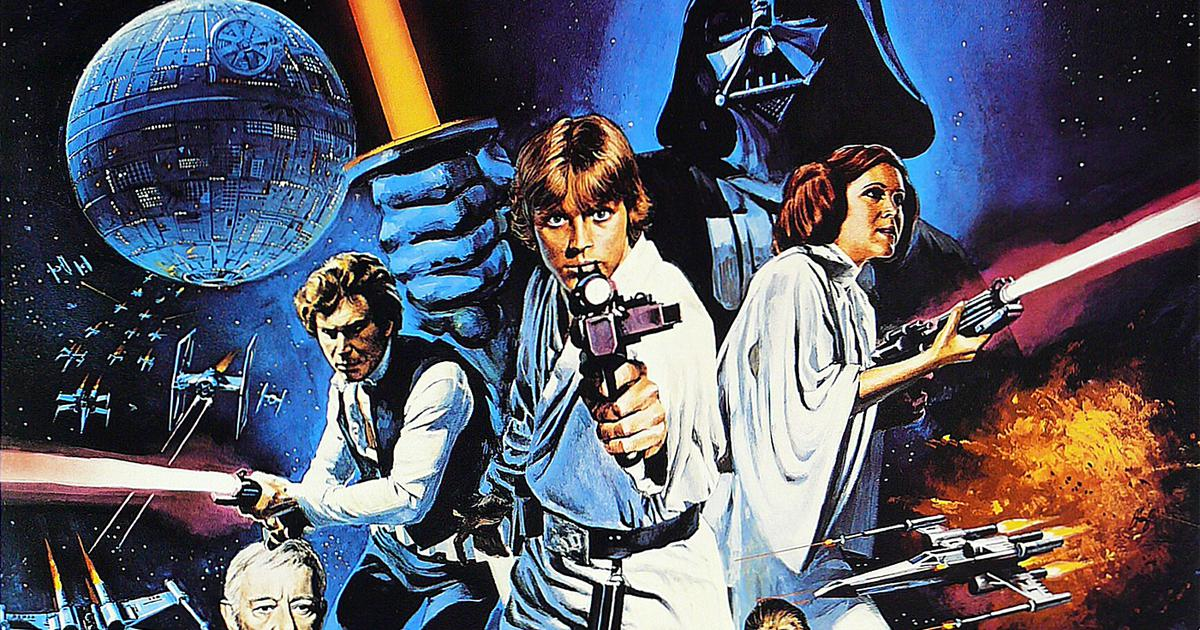

In [25]:
showarray(np.float32(PIL.Image.open('../sw1.png'))/255)

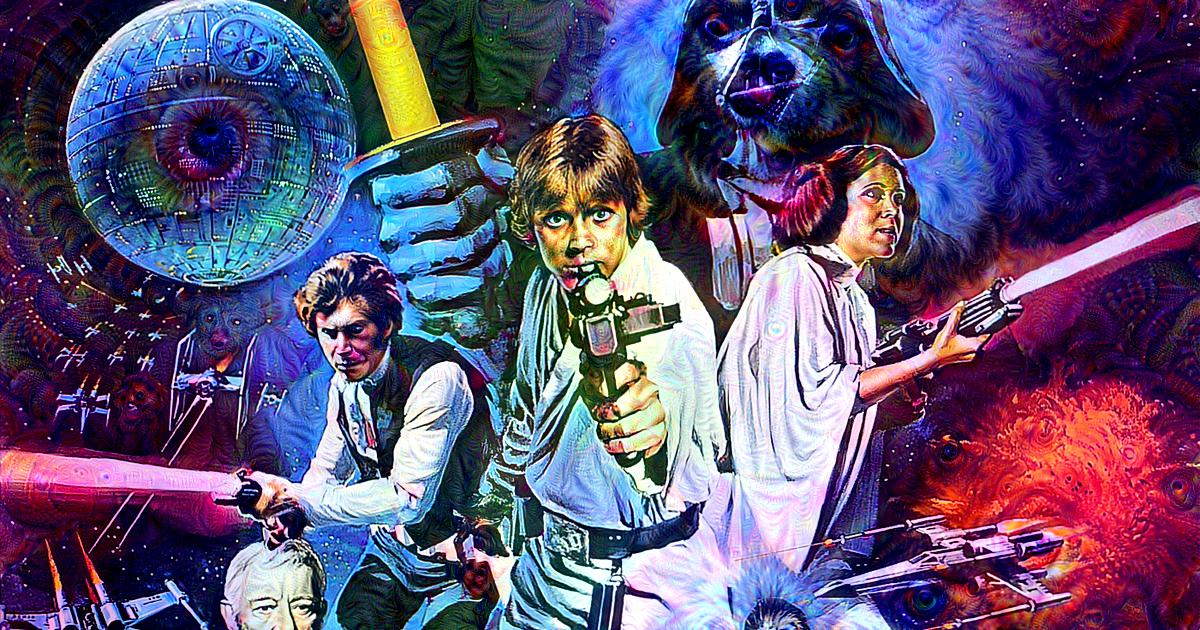

In [30]:
render_deepdream(tf.square(T('mixed4c')), img1, iter_n = 10, step = 1.5, octave_n = 18, octave_scale = 1.4)